<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/basic_level_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

# Creacion, entrenamiento y prueba de la red

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import time

# Cleaning the VRAM memory
#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats(device=None)
#print("Espacio disponible en GPU (Gb): ", torch.cuda.memory_allocated()*1e-9)


In [6]:
# Paths

labels_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/labels.csv'
names_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/names.csv'
images_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/images.npz'

labels_raw = pd.read_csv(labels_path, header = None)
labels_raw = labels_raw.values.tolist()
labels = []
for label in labels_raw:
  labels.append(label[0])

names = pd.read_csv(names_path, header = None)
names = names.values.tolist()

images = np.load(images_path)
images = images['arr_0']

Negativos:  581 
Nuclear:  1368 
Citoplasmaticos:  676 
Mitotico:  161
Pesos de cada clase:  tensor([0.1697, 0.0721, 0.1458, 0.6124])


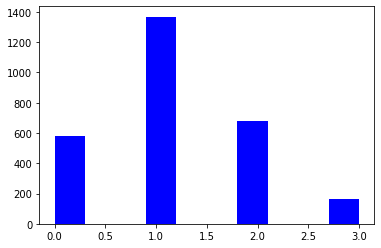

Etiquetas divididas para cada muestra:  [['NuclearHomogeneous', 'CytoplasmicFibrillar'], ['NuclearHomogeneous', 'NucleolarHomogeneous', 'CytoplasmicSpeckled'], ['CoarseSpeckled', 'CytoplasmicReticularAMA'], ['CoarseSpeckled', 'CytoplasmicFibrillar'], ['MultipleNuclearDots', 'CytoplasmicReticularAMA'], ['NucleolarClumpy', 'DSF-70'], ['NuclearHomogeneous', 'NucleolarHomogeneous', 'CytoplasmicReticularAMA'], ['Negative'], ['CoarseSpeckled', 'CytoplasmicSpeckled'], ['Centromere'], ['MultipleNuclearDots'], ['CoarseSpeckled', 'CytoplasmicSpeckled'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['CoarseSpeckled', 'CytoplasmicReticularAMA'], ['NuclearHomogeneous', 'NucleolarHomogeneous'], ['CoarseSpeckled', 'CytoplasmicSpeckled'], ['NuclearHomogeneous', 'CytoplasmicReticularAMA'], ['Negative'], ['Negative'], ['CytoplasmicSpeckled'], ['NuclearHomogeneous', 'FineSpeckled', 'CytoplasmicFibrillar'], ['NuclearHomogeneous', 'NucleolarClumpy'], ['FineSpeckled', 'NUMA-1MSA-1'], ['FineSpeckled', 'Cytoplas

In [7]:
# Preparando la data para tener 4 clases distintas

split_labels = []
basic_level_labels_raw = []
basic_level_labels = []
basic_level_labels_to_model = []

for label in labels: # Separamos las etiquetas para cada muestra
  split_labels.append(label.split("_"))

for label in split_labels:
  group = []
  for basic_label in label:
    if (basic_label == "NuclearHomogeneous" or basic_label == "DSF-70" or basic_label == "Centromere" or 
        basic_label == "FineSpeckled" or basic_label == "CoarseSpeckled" or basic_label == "MultipleNuclearDots" or
        basic_label == "FewNuclearDots" or basic_label == "NucleolarHomogeneous" or basic_label == "NucleolarClumpy" or
        basic_label == "NucleolarSpeckled" or basic_label == "NuclearMembranous" or basic_label == "NuclearMembranepores" or
        basic_label == "PCNA" or basic_label == "PCNA(ProliferatingCellNuclearAntigen)" or basic_label == "SCl-70"):  # # Hay algunas imagenes con la etiqueta PCNA(ProliferatingCellNuclearAntigen)
      group.append(1)
    elif (basic_label == "CytoplasmicSpeckled" or basic_label == "CytolplasmicSpeckled" or basic_label == "CytoplasmicFibrillar" or # Hay algunas imagenes con la etiqueta CytolplasmicSpeckled
          basic_label == "CytoplasmicReticularAMA" or basic_label == "CytoplasmicPolarGolgiLike" or basic_label == "Tubulin"):
      group.append(2)
    elif (basic_label == "Centriole" or basic_label == "NUMA-1MSA-1" or basic_label == "Midbody(MSA-2)"):
      group.append(3)
    elif (basic_label == "Negative"):
      group.append(0)
    else:
      print("LOS QUE FALTAN: ", basic_label)
  basic_level_labels_raw.append(group)

for group in basic_level_labels_raw:
  basic_level_labels.append(list(set(group)))

for group in basic_level_labels:
  total_label_group = [0, 0, 0, 0]
  for clase in group:
    total_label_group[clase] = 1
  basic_level_labels_to_model.append(total_label_group)

Negatives = 0
Nuclear = 0
Cytoplasmic = 0
Mitotic = 0
weights = []
histogram_data = []

for labels in basic_level_labels_to_model:  
  if labels[0] == 1:
    Negatives += 1
    histogram_data.append(0)
  if labels[1] == 1:
    Nuclear += 1
    histogram_data.append(1)
  if labels[2] == 1:
    Cytoplasmic += 1
    histogram_data.append(2)
  if labels[3] == 1:
    Mitotic += 1
    histogram_data.append(3)

# Creacion de un vector de pesos para balancear las clases
weights.append(Negatives)
weights.append(Nuclear)
weights.append(Cytoplasmic)
weights.append(Mitotic)
weights = np.array(weights)
weights = 1/weights
weights = weights/np.sum(weights)
weights = torch.FloatTensor(weights)

print("Negativos: ", Negatives, "\nNuclear: ", Nuclear,
      "\nCitoplasmaticos: ", Cytoplasmic, "\nMitotico: ", Mitotic)
print("Pesos de cada clase: ", weights)
plt.hist(histogram_data, facecolor = 'blue', alpha = 1)
plt.show()

print("Etiquetas divididas para cada muestra: ", split_labels)
print("Etiquetas traducidas a los 4 grandes grupos: ", basic_level_labels_raw)
print("Etiquetas traducidas a los 4 grandes grupos (sin valores repetidos): ", basic_level_labels)

print("\nEtiquetas finales para el modelo: ", basic_level_labels_to_model)
print("Tamano de arreglo de etiquetas finales: ", len(basic_level_labels_to_model))

# Division de la data para entrenar, validar y probar la red
x_train, x_val_test, y_train, y_val_test = train_test_split(images, basic_level_labels_to_model, test_size = 0.3)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5)

print("\nMuestras en el set de entrenamiento: ", np.shape(x_train))
print("Muestras en el set de validacion: ", np.shape(x_val))
print("Muestras en el set de pruebas: ", np.shape(x_test))

tensor([1., 0., 0., 0.])


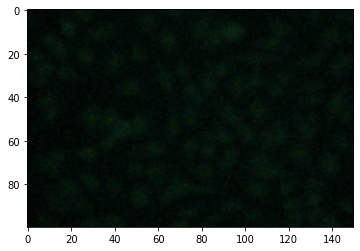

tensor([0., 1., 0., 0.])


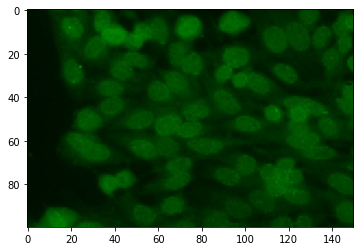

tensor([0., 1., 1., 0.])


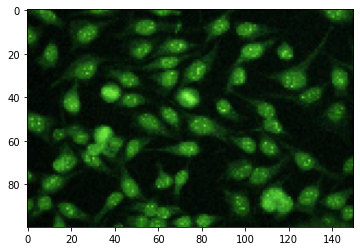

In [8]:
#Clase Dataset Personaliazdo

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Creando Dataloader para los conjuntos de entrenamiento y prueba

Batch_size = 64

train_data = CustomImageDataset(x_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=True)

val_data = CustomImageDataset(x_val, y_val)
val_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=True)

test_data = CustomImageDataset(x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=Batch_size, shuffle=True)


images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(val_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(test_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

In [9]:
# Creacion de la InmunoNet

class InmunoNet(nn.Module):
  def __init__(self, numChannels, numClasses):
    super(InmunoNet, self).__init__()

    # Se inicializa la primera capa convolucional (CONV => RELU => POOL layers)
    self.conv1 = nn.Conv2d(in_channels = numChannels, out_channels = 20, kernel_size = (6, 6), stride = (1, 1)) # 3 canales de entrada y 20 de salida
    self.batchNorm1 = nn.BatchNorm2d(20)
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # Se inicializa la segunda capa convolucional (CONV => RELU => POOL layers)
    self.conv2 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = (6, 6), stride = (1, 1)) # 20 canales de entrada y 40 de salida
    self.batchNorm2 = nn.BatchNorm2d(40)
    self.maxpool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

    # Se inicializa la tercera capa convolucional (CONV => RELU => POOL layers)
    self.conv3 = nn.Conv2d(in_channels = 40, out_channels = 80, kernel_size = (4, 4), stride = (1, 1)) # 40 canales de entrada y 80 de salida
    self.batchNorm3 = nn.BatchNorm2d(80)
    self.maxpool3 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

    # Se inicializa la tercera capa convolucional (CONV => RELU => POOL layers)
    self.conv4 = nn.Conv2d(in_channels = 80, out_channels = 240, kernel_size = (4, 4), stride = (1, 1)) # 80 canales de entrada y 240 de salida
    self.batchNorm4 = nn.BatchNorm2d(240)
    self.maxpool4 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

    # initialize first set of FC => RELU layers
    self.fc1 = nn.Linear(in_features = 4320, out_features = 4320)

    # initialize second set of FC => RELU layers
    self.fc2 = nn.Linear(in_features = 4320, out_features = 2000)

    # initialize third set of FC => RELU layers
    self.fc3 = nn.Linear(in_features = 2000, out_features = 1000)

    # initialize fouth set of FC => RELU layers
    self.fc4 = nn.Linear(in_features = 1000, out_features = 500)

    # Final set of FC
    self.fcout = nn.Linear(in_features = 500, out_features = numClasses)
    
    # Activation functions
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    
    # Regularization
    self.dropout = nn.Dropout(0.3) # Dropout con 40% de porbabilidades de desactivar cada neuronar
    self.conv_dropout = nn.Dropout(0.3) # Dropout de 40% para las capas convolucionales

  def forward(self, x):

    # Modificando el orden de los tensores (batch, canales, alto, ancho)
    x = x.permute(0, 3, 1, 2)

    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    #x = self.conv_dropout(x)
    x = self.batchNorm1(x)
    x = self.relu(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    #x = self.conv_dropout(x)
    x = self.batchNorm2(x)
    x = self.relu(x)
    x = self.maxpool2(x)

    # pass the output from the previous layer through the third set of CONV => RELU => POOL layers
    x = self.conv3(x)
    #x = self.conv_dropout(x)
    x = self.batchNorm3(x)
    x = self.relu(x)
    x = self.maxpool3(x)

    # pass the output from the previous layer through the fourth set of CONV => RELU => POOL layers
    x = self.conv4(x)
    #x = self.conv_dropout(x)
    x = self.batchNorm4(x)
    x = self.relu(x)
    x = self.maxpool4(x)
    
    # flatten the output from the previous layer and pass it through our first set of FC => RELU layers
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.relu(x)
    
    # pass the output from the previous layer through our second set of FC => RELU layers
    x = self.fc2(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output from the previous layer through our third set of FC => RELU layers
    x = self.fc3(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output from the previous layer through our third set of FC => RELU layers
    x = self.fc4(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output to our softmax classifier to get our output predictions
    x = self.fcout(x)
    output = x
    #output = self.sigmoid(x)
    
    # return the output predictions
    return output

In [10]:
# Funcion para el entrenamiento y validacion de la red

def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
  # Inicializamos dos arreglos para guardar el costo por epoca para el entrenamiento y la validacion
  training_cost = []
  validation_cost = []
  aux_acc = 0.5
  
  for epoch in range(epochs):
    # Se inicializan la perdida del entrenamientos y de la validacion en 0
    training_batch_loss = []
    validation_batch_loss = []
    
    # Empieza el entrenamiento de la red
    model.train()
    Y_total = torch.ones((1,4)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
    Y_hat_total = torch.ones((1,4)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
    for batch in iter(train_loader):
      X, Y = batch
      X = X.to(device, torch.float32)
      Y = Y.reshape((len(Y), 4))
      Y = Y.to(device, torch.float32)
      Y_hat = model(X)
      loss = loss_fn(Y_hat, Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_batch_loss.append(loss.data.item())
      Y_total = torch.cat((Y_total, Y), dim = 0)              # Concatenamos las salidas de cada lote
      Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)  # Concatenamos las salidas que predice el modelo de cada lote
    training_cost_epoch = np.mean(training_batch_loss)
    training_cost.append(training_cost_epoch)
    Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total[Y_hat_total > 0.8] = 1
    Y_hat_total[Y_hat_total < 1] = 0
    #print("Prediccion entrenamiento: \n", Y_hat_total)
    
    # Metricas
    # GPU
    if (device == "cuda"):
      training_epoch_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      training_epoch_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted')
      training_epoch_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted')
      training_epoch_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted') 
    # CPU
    else:
      training_epoch_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      training_epoch_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')
      training_epoch_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')
      training_epoch_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')

    # Empieza la validacion de la red
    model.eval()
    Y_total = torch.ones((1,4)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
    Y_hat_total = torch.ones((1,4)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
    for batch in iter(val_loader):
      X, Y = batch
      X = X.to(device, torch.float32)
      Y = Y.reshape((len(Y), 4))
      Y = Y.to(device, torch.float32)
      Y_hat = model(X)
      loss = loss_fn(Y_hat, Y)
      validation_batch_loss.append(loss.data.item())
      Y_total = torch.cat((Y_total, Y), dim = 0)              # Concatenamos las salidas de cada lote
      Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)  # Concatenamos las salidas que predice el modelo de cada lote
    validation_cost_epoch = np.mean(validation_batch_loss)
    validation_cost.append(validation_cost_epoch)
    Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total[Y_hat_total > 0.8] = 1
    Y_hat_total[Y_hat_total < 1] = 0
    #print("Prediccion validacion: \n", Y_hat_total)
    
    # Metricas
    # GPU
    if (device == "cuda"):
      validation_epoch_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      validation_epoch_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted')
      validation_epoch_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted')
      validation_epoch_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted') 
    # CPU
    else:
      validation_epoch_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      validation_epoch_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')
      validation_epoch_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')
      validation_epoch_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')
    
    # Guardando los parametros del modelo segun la exactitud de la validacion (Accuracy)
    if( validation_epoch_acc > aux_acc):
      torch.save(model.state_dict(), 'drive/MyDrive/Colab_Notebooks/Tesis/Models/Basic_level_model.pt')
      aux_acc = validation_epoch_acc
      print("Modelo guardado con Accuracy = ", aux_acc, "\n")
    
    # Imprimiendo datos del modelos
    print("Epoca: ", (epoch + 1), "/", epochs)
    print("Costo de entrenamiento ", round(training_cost_epoch, 5))
    print("Costo de validacion ", round(validation_cost_epoch, 5))
    print("Metricas del entrenmaiento:\n", "Exactitud: ", round(training_epoch_acc, 2), " Precision: ",
          round(training_epoch_pre, 2), " Recall: ", round(training_epoch_recall, 2), " F1: ", round(training_epoch_F1, 2))
    print("Metricas de la validacion:\n", "Exactitud: ", round(validation_epoch_acc, 2), " Precision: ",
          round(validation_epoch_pre, 2), " Recall: ", round(validation_epoch_recall, 2), " F1: ", round(validation_epoch_F1, 2), "\n")
  
  return training_cost, validation_cost   

  # Accuracy = TP + TN / (TP + TN + FP + FN)
  # Precision = TP / (TP + FP)
  # Recall = TP / (TP + FN) 
  # F1 = 2 * (Precision * Recall) / (Precision + Recall)

In [11]:
def test_model(model, test_loader, device):
  
  # Cargando el modelo con mayor exactitud en el set de validacion
  model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/Basic_level_model.pt'))
  print("Modelo cargado.\n")

  # Empieza la prueba del modelo
  model.eval()
  Y_total = torch.ones((1,4)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
  Y_hat_total = torch.ones((1,4)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
  for batch in iter(test_loader):
    X, Y = batch
    X = X.to(device, torch.float32)
    Y = Y.reshape((len(Y), 4))
    Y = Y.to(device, torch.float32)
    Y_hat = model(X)
    Y_total = torch.cat((Y_total, Y), dim = 0)               # Concatenamos las salidas de cada lote
    Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)   # Concatenamos las salidas que predice el modelo de cada lote
  Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
  Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
  Y_hat_total[Y_hat_total > 0.8] = 1
  Y_hat_total[Y_hat_total < 1] = 0
  
  # Metricas
  # GPU
  if (device == "cuda"):
    test_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
    test_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted')
    test_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted')
    test_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted') 
    test_confusion_matrix = multilabel_confusion_matrix(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
  # CPU
  else:
    test_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')
    test_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')
    test_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted')
    test_confusion_matrix = multilabel_confusion_matrix(Y_total.detach().numpy(), Y_hat_total.detach().numpy())

  #print("Y: ", Y)
  #print("Y_hat: ", Y_hat_total)
  return test_acc, test_pre, test_recall, test_F1, test_confusion_matrix


In [ ]:
# Creacion del modelo

basic_level_model = InmunoNet(3, 4)
#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss(weight = weights)
device = "cpu"
optimizer = torch.optim.Adam(basic_level_model.parameters(), lr = 0.001)
epochs = 200
if torch.cuda.is_available():
    basic_level_model.cuda()
    loss_fn.cuda()
    device = "cuda"

# Entrenamiento y validacion

start_time = time.time()
training_cost, validation_cost = train_model(
    basic_level_model,
    optimizer,
    loss_fn, 
    train_dataloader, 
    val_dataloader,  
    epochs,
    device)
final_time = time.time() - start_time

print("Estructura del modelo: \n", basic_level_model, "\n")
print('Tiempo de entrenamiento:', round(final_time/60, 3), " min \n")
plt.plot(range(epochs), training_cost, color = "r", label = "Conjunto de entrenamiento")
plt.plot(range(epochs), validation_cost, color = "b", label = "Conjunto de validacion")
plt.title("Coste por epoca")
plt.xlabel("Epoca")
plt.ylabel("Coste")
plt.legend()
plt.show()

In [ ]:
# Prueba del modelo

start_time = time.time()
test_acc, test_pre, test_recall, test_F1, test_conf_mat = test_model(
    basic_level_model, 
    test_dataloader, 
    device)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_pre, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2), 
      "\n Matriz de Confusion: \n", test_conf_mat)